In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
import matplotlib.pyplot as plt
import time
import numpy as np

from models.varying_taskhead_length import MTL1Layer, MTL3Layer, MTL5Layer, MTL7Layer, MTL9Layer, MTL11Layer, MTL13Layer, MTL15Layer
from utils.pruning import get_f1_and_lat
from utils.data import FacesDataset, data_transform
from utils.pruning import prune_model, prune_other_tasks

In [2]:
### Load in the data
folder = 'UTKFace'
transform = data_transform()
dataset = FacesDataset(folder=folder, transform=transform)

### Set up train and val datasets and loaders
train_len = int(len(dataset)*0.8)
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len], torch.Generator().manual_seed(8))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

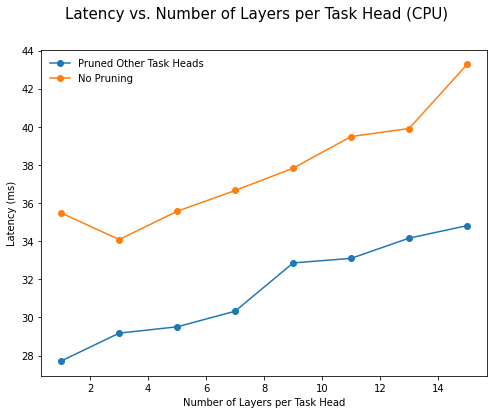

In [3]:
### Test inference before and after pruning for each network
def get_lat(model, eval_dataset, eval_dataloader, tasks, mtl_model=True):
    # Get latency
    latencies = []
    for i, sample in enumerate(eval_dataset):
        model = model.cpu()
        start = time.time()
        image = sample[0].unsqueeze(0)
        output = model(image.cpu())
        lat = time.time() - start
        if i >= 1: # skip first sample (to be consistent with GPU code)
            latencies.append(lat)
        if i >= 100:
            break
    mean_lat = np.mean(latencies)
    std_lat = np.std(latencies)


    return [mean_lat, std_lat]


latencies = []  # of form [[num_layers, pruned_lat, unpruned_lat], ...]
tasks = ['age']

# Load models
model_list = [MTL1Layer(), MTL3Layer(), MTL5Layer(), MTL7Layer(), MTL9Layer(),
              MTL11Layer(), MTL13Layer(), MTL15Layer()]

# Get latencies for models
for i, model in enumerate(model_list):
    i = 2*(i+1)-1
    [mean_lat, std_lat] = get_lat(model=model,
                                  eval_dataset=val_dataset,
                                  eval_dataloader=val_loader,
                                  tasks=tasks,
                                  mtl_model=True)
    # Prune model
    pruned_model = prune_other_tasks(model, task1='gender', task2='ethnicity', PRUNING_PERCENT=0)
    [pruned_mean_lat, pruned_std_lat] = get_lat(model=pruned_model,
                                                eval_dataset=val_dataset,
                                                eval_dataloader=val_loader,
                                                tasks=tasks,
                                                mtl_model=True)
    
    latencies.append([i, pruned_mean_lat*1000, mean_lat*1000])
    
    
# Plot both latencies by task head length
lat_arr = np.array(latencies)

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Latency vs. Number of Layers per Task Head (CPU)', fontsize=15)

ax.plot(lat_arr[:, 0], lat_arr[:, 1], label='Pruned Other Task Heads', marker='o')
ax.plot(lat_arr[:, 0], lat_arr[:, 2], label='No Pruning', marker='o')
plt.ylabel('Latency (ms)')
plt.xlabel('Number of Layers per Task Head')
plt.legend(loc="upper left", frameon=False)

plt.show()

In [4]:
### Test inference before and after pruning for each network
def get_lat(model, eval_dataset, eval_dataloader, tasks, mtl_model=True):
    # Get latency
    latencies = []
    for i, sample in enumerate(eval_dataset):
        model = model.cuda()
        start = time.time()
        image = sample[0].unsqueeze(0)
        output = model(image.cuda())
        lat = time.time() - start
        if i >= 1: # skip first sample (to avoid slow GPU processing on first sample)
            latencies.append(lat)
        if i >= 100:
            break
    mean_lat = np.mean(latencies)
    std_lat = np.std(latencies)


    return [mean_lat, std_lat]


latencies = []  # of form [[num_layers, pruned_lat, unpruned_lat], ...]
tasks = ['age']

# Load models
model_list = [MTL1Layer(), MTL3Layer(), MTL5Layer(), MTL7Layer(), MTL9Layer(),
              MTL11Layer(), MTL13Layer(), MTL15Layer()]

# Run through loop once to initialize GPU (otherwise the first point in the graph is an outlier)
for i, model in enumerate(model_list):
    i = 2*(i+1)-1
    [mean_lat, std_lat] = get_lat(model=model,
                                  eval_dataset=val_dataset,
                                  eval_dataloader=val_loader,
                                  tasks=tasks,
                                  mtl_model=True)
    # Prune model
    pruned_model = prune_other_tasks(model, task1='gender', task2='ethnicity', PRUNING_PERCENT=0)
    [pruned_mean_lat, pruned_std_lat] = get_lat(model=pruned_model,
                                                eval_dataset=val_dataset,
                                                eval_dataloader=val_loader,
                                                tasks=tasks,
                                                mtl_model=True)
    
    latencies.append([i, pruned_mean_lat*1000, mean_lat*1000])

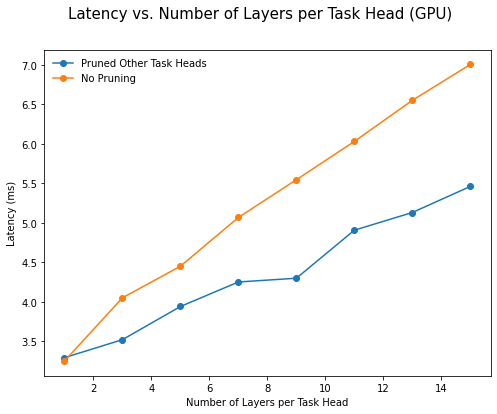

In [5]:
# Plot both latencies by task head length
lat_arr = np.array(latencies)

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Latency vs. Number of Layers per Task Head (GPU)', fontsize=15)

ax.plot(lat_arr[:, 0], lat_arr[:, 1], label='Pruned Other Task Heads', marker='o')
ax.plot(lat_arr[:, 0], lat_arr[:, 2], label='No Pruning', marker='o')
plt.ylabel('Latency (ms)')
plt.xlabel('Number of Layers per Task Head')
plt.legend(loc="upper left", frameon=False)

plt.show()

In [6]:
# Note: plotted the GPU curve too since the trends are slightly different (GPU shows expected trend more clearly)